# Analyse en Composantes Principales (ACP)  
Ce notebook applique l'ACP au jeu de données mondial 2023,  
avec un focus particulier sur le Maroc et la variable « région ».

## 1. Import des bibliothèques et chargement du jeu de données
Nous utilisons le Global Country Information Dataset 2023

In [1]:
import sys
print(sys.executable)

C:\ProgramData\anaconda3\python.exe


In [2]:
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib as mpl

# Configuration pour afficher les caractères français
plt.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['axes.unicode_minus'] = False

# Pour éviter les warnings
import warnings
warnings.filterwarnings('ignore')

### Chargement des données

In [3]:
# Chargement du fichier csv
try:
    df = pd.read_csv('world-data-2023.csv')
    print(f"Dataset chargé avec succès: {df.shape[0]} pays et {df.shape[1]} variables")
except Exception as e:
    print(f"Erreur lors du chargement: {e}")

# Suppression des pays outliers dès le début
outliers = ['Somalia', 'Greece', 'Solomon Islands']
original_shape = df.shape[0]
df = df[~df['Country'].isin(outliers)]

# Réinitialisation des index pour éviter les "trous" dans la numérotation
df = df.reset_index(drop=True)

print(f"\nOutliers supprimés: {', '.join(outliers)}")
print(f"Nombre de pays: {original_shape} → {df.shape[0]} (-{original_shape - df.shape[0]})")

# Affichage des premières lignes pour vérification
print("\nAperçu des données après suppression des outliers:")
df.head(3)

Dataset chargé avec succès: 194 pays et 35 variables

Outliers supprimés: Somalia, Greece, Solomon Islands
Nombre de pays: 194 → 191 (-3)

Aperçu des données après suppression des outliers:


,Country,Density\n(P/Km2),Abbreviation,Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Calling Code,Capital/Major City,Co2-Emissions,...,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population,Latitude,Longitude
0,Uruguay,20,UY,82.60%,"176,215","22,000",13.86,598.0,Montevideo,"6,766",...,16.20%,5.05,"3,461,734",64.00%,20.10%,41.80%,8.73%,"3,303,394",-32.522779,-55.765835
1,Saudi Arabia,16,SA,80.80%,"2,149,690","252,000",17.80,966.0,Riyadh,"563,449",...,15.00%,2.61,"34,268,528",55.90%,8.90%,15.70%,5.93%,"28,807,838",23.885942,45.079162
2,Kazakhstan,7,KZ,80.40%,"2,724,900","71,000",21.77,7.0,Astana,"247,207",...,38.80%,3.25,"18,513,930",68.80%,11.70%,28.40%,4.59%,"10,652,915",48.019573,66.923684


## 2. Préparation et exploration des données
- Vérification des valeurs manquantes
- Sélection des variables numériques
- Identification du Maroc dans le jeu de données

In [4]:
# Vérification des types de données
print("Types de données:")
print(df.dtypes)

# Vérification des valeurs manquantes initiales
print("\nValeurs manquantes par colonne:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Types de données:
Country                                       object
Density\n(P/Km2)                              object
Abbreviation                                  object
Agricultural Land( %)                         object
Land Area(Km2)                                object
Armed Forces size                             object
Birth Rate                                   float64
Calling Code                                 float64
Capital/Major City                            object
Co2-Emissions                                 object
CPI                                           object
CPI Change (%)                                object
Currency-Code                                 object
Fertility Rate                               float64
Forested Area (%)                             object
Gasoline Price                                object
GDP                                           object
Gross primary education enrollment (%)        object
Gross tertiary education enr

### Sélection des variables numériques

In [5]:
# Création de la colonne Urban_ratio en pourcentage
if 'Urban_population' in df.columns and 'Population' in df.columns:
    try:
        # Nettoyer et convertir les deux colonnes si nécessaire
        df['Urban_population'] = pd.to_numeric(df['Urban_population'].astype(str).str.replace(',', ''), errors='coerce')
        df['Population'] = pd.to_numeric(df['Population'].astype(str).str.replace(',', ''), errors='coerce')

        df['Urban_ratio'] = (df['Urban_population'] / df['Population']) * 100
    except Exception as e:
        print(f"Erreur lors de la création de Urban_ratio: {e}")

# Meilleure extraction des colonnes numériques
numeric_cols = []
for col in df.columns:
    # On exclut Country, Capital, Currency et autres colonnes clairement non numériques
    if col in ['Country', 'Abbreviation', 'Capital/Major City', 'Currency-Code',
               'Largest city', 'Official language']:
        continue

    try:
        # Créer une série temporaire pour le nettoyage
        temp_series = df[col].copy()

        # Si c'est un objet (string), on nettoie les caractères non numériques
        if df[col].dtype == 'object':
            temp_series = temp_series.str.replace('%', '')
            temp_series = temp_series.str.replace(',', '')
            temp_series = pd.to_numeric(temp_series, errors='coerce')

        # Si la colonne a suffisamment de valeurs non-NA (moins de 50% manquantes)
        if temp_series.notna().sum() > 0.5 * len(df):
            numeric_cols.append(col)

        # Mettre à jour la colonne nettoyée dans le DataFrame
        df[col] = temp_series

    except:
        pass

print(f"\nColonnes numériques identifiées: {len(numeric_cols)}")
print(numeric_cols)



Colonnes numériques identifiées: 27
['Density\n(P/Km2)', 'Agricultural Land( %)', 'Land Area(Km2)', 'Armed Forces size', 'Birth Rate', 'Calling Code', 'Co2-Emissions', 'CPI', 'CPI Change (%)', 'Fertility Rate', 'Forested Area (%)', 'Gross primary education enrollment (%)', 'Gross tertiary education enrollment (%)', 'Infant mortality', 'Life expectancy', 'Maternal mortality ratio', 'Out of pocket health expenditure', 'Physicians per thousand', 'Population', 'Population: Labor force participation (%)', 'Tax revenue (%)', 'Total tax rate', 'Unemployment rate', 'Urban_population', 'Latitude', 'Longitude', 'Urban_ratio']


### Sélection des variables pertinentes pour l'ACP

In [6]:
# Liste des variables pertinentes sélectionnées pour l'Analyse en Composantes Principales (ACP)
variables_pca = [
    'Fertility Rate',                               # Taux de fécondité
    'Infant mortality',                             # Mortalité infantile
    'Life expectancy',                              # Espérance de vie
    'Physicians per thousand',                      # Médecins pour mille habitants
    'Unemployment rate',                            # Taux de chômage
    'Tax revenue (%)',                              # Revenus fiscaux en pourcentage du PIB
    'Urban_ratio',                                  # Population urbaine                               CONVERTED TO A RATIO
    'Population: Labor force participation (%)',    # Taux de participation à la population active
    'Agricultural Land( %)',                        # Pourcentage de terres agricoles
    'Gross primary education enrollment (%)',       # Taux brut de scolarisation primaire
    'Gross tertiary education enrollment (%)',      # Taux brut de scolarisation dans le supérieur
]  #WE ALSO NEED TO ADD THE QUALITY OF REPRESENTATION OF EACH COUNTRY

# Extraction des colonnes pertinentes du DataFrame
df_selected = df[variables_pca].copy()

### Nettoyage des données numériques

In [7]:
# Initialisation d'un nouveau DataFrame pour contenir les colonnes numériques nettoyées
X_numeric = pd.DataFrame()

# Conversion des colonnes en type numérique avec nettoyage des caractères non numériques
for col in variables_pca:
    if df_selected[col].dtype == 'object':
        # Nettoyer les chaînes de caractères : enlever % et , (virgules de milliers)
        cleaned_col = df_selected[col].str.replace('%', '', regex=False)\
                                       .str.replace(',', '', regex=False)\
                                       .str.replace(' ', '', regex=False)
        X_numeric[col] = pd.to_numeric(cleaned_col, errors='coerce')
    else:
        # Si la colonne est déjà numérique, on la garde telle quelle
        X_numeric[col] = df_selected[col]

# Vérification finale des colonnes utilisées
print("\nColonnes prêtes pour l'ACP :", list(X_numeric.columns))
print(X_numeric.dtypes)

# Vérification des valeurs manquantes après conversion
print("\nValeurs manquantes après conversion numérique:")
missing_after_conversion = X_numeric.isnull().sum()
print(missing_after_conversion[missing_after_conversion > 0])


Colonnes prêtes pour l'ACP : ['Fertility Rate', 'Infant mortality', 'Life expectancy', 'Physicians per thousand', 'Unemployment rate', 'Tax revenue (%)', 'Urban_ratio', 'Population: Labor force participation (%)', 'Agricultural Land( %)', 'Gross primary education enrollment (%)', 'Gross tertiary education enrollment (%)']
Fertility Rate                               float64
Infant mortality                             float64
Life expectancy                              float64
Physicians per thousand                      float64
Unemployment rate                            float64
Tax revenue (%)                              float64
Urban_ratio                                  float64
Population: Labor force participation (%)    float64
Agricultural Land( %)                        float64
Gross primary education enrollment (%)       float64
Gross tertiary education enrollment (%)      float64
dtype: object

Valeurs manquantes après conversion numérique:
Fertility Rate                

### Traitement des valeurs manquantes

In [8]:
# Élimination des colonnes avec trop de valeurs manquantes (seuil: 30%)
threshold = 0.3 * len(X_numeric)
X_clean = X_numeric.dropna(axis=1, thresh=threshold)
print(f"\nAprès nettoyage: {X_clean.shape[1]} variables numériques conservées")

# Remplacement des valeurs manquantes restantes par la médiane
X_clean = X_clean.fillna(X_clean.median())

# Conservation du pays pour référence
country_data = df['Country'].reset_index(drop=True)
X_final = pd.concat([country_data, X_clean], axis=1)


Après nettoyage: 11 variables numériques conservées


### Identification du Maroc dans le dataset

In [9]:
# Recherche du Maroc
morocco_idx = df[df['Country'] == 'Morocco'].index
if len(morocco_idx) > 0:
    print(f"\nLe Maroc est présent dans le jeu de données à l'index {morocco_idx[0]}")
    print("Données du Maroc:")
    print(df.loc[morocco_idx[0], ['Country'] + list(X_clean.columns)])
else:
    print("\nLe Maroc n'est pas présent dans le jeu de données sous le nom 'Morocco'")
    # Recherche alternative avec un nom différent
    alternative_names = ['Maroc', 'Marruecos', 'المغرب']
    for name in alternative_names:
        alt_idx = df[df['Country'] == name].index
        if len(alt_idx) > 0:
            print(f"Le Maroc est présent sous le nom '{name}' à l'index {alt_idx[0]}")
            morocco_idx = alt_idx
            break

# Liste des variables utilisées pour l'ACP
print("\nListe des variables utilisées pour l'ACP:", list(X_clean.columns))


Le Maroc est présent dans le jeu de données à l'index 23
Données du Maroc:
Country                                       Morocco
Fertility Rate                                   2.42
Infant mortality                                 19.2
Life expectancy                                  76.5
Physicians per thousand                          0.73
Unemployment rate                                9.02
Tax revenue (%)                                  21.9
Urban_ratio                                  62.24513
Population: Labor force participation (%)        45.3
Agricultural Land( %)                            68.5
Gross primary education enrollment (%)          113.9
Gross tertiary education enrollment (%)          35.9
Name: 23, dtype: object

Liste des variables utilisées pour l'ACP: ['Fertility Rate', 'Infant mortality', 'Life expectancy', 'Physicians per thousand', 'Unemployment rate', 'Tax revenue (%)', 'Urban_ratio', 'Population: Labor force participation (%)', 'Agricultural Land( %)',

## 3. Corrélations entre variables
Nous calculons les corrélations entre variables pour mieux comprendre le jeu de données.

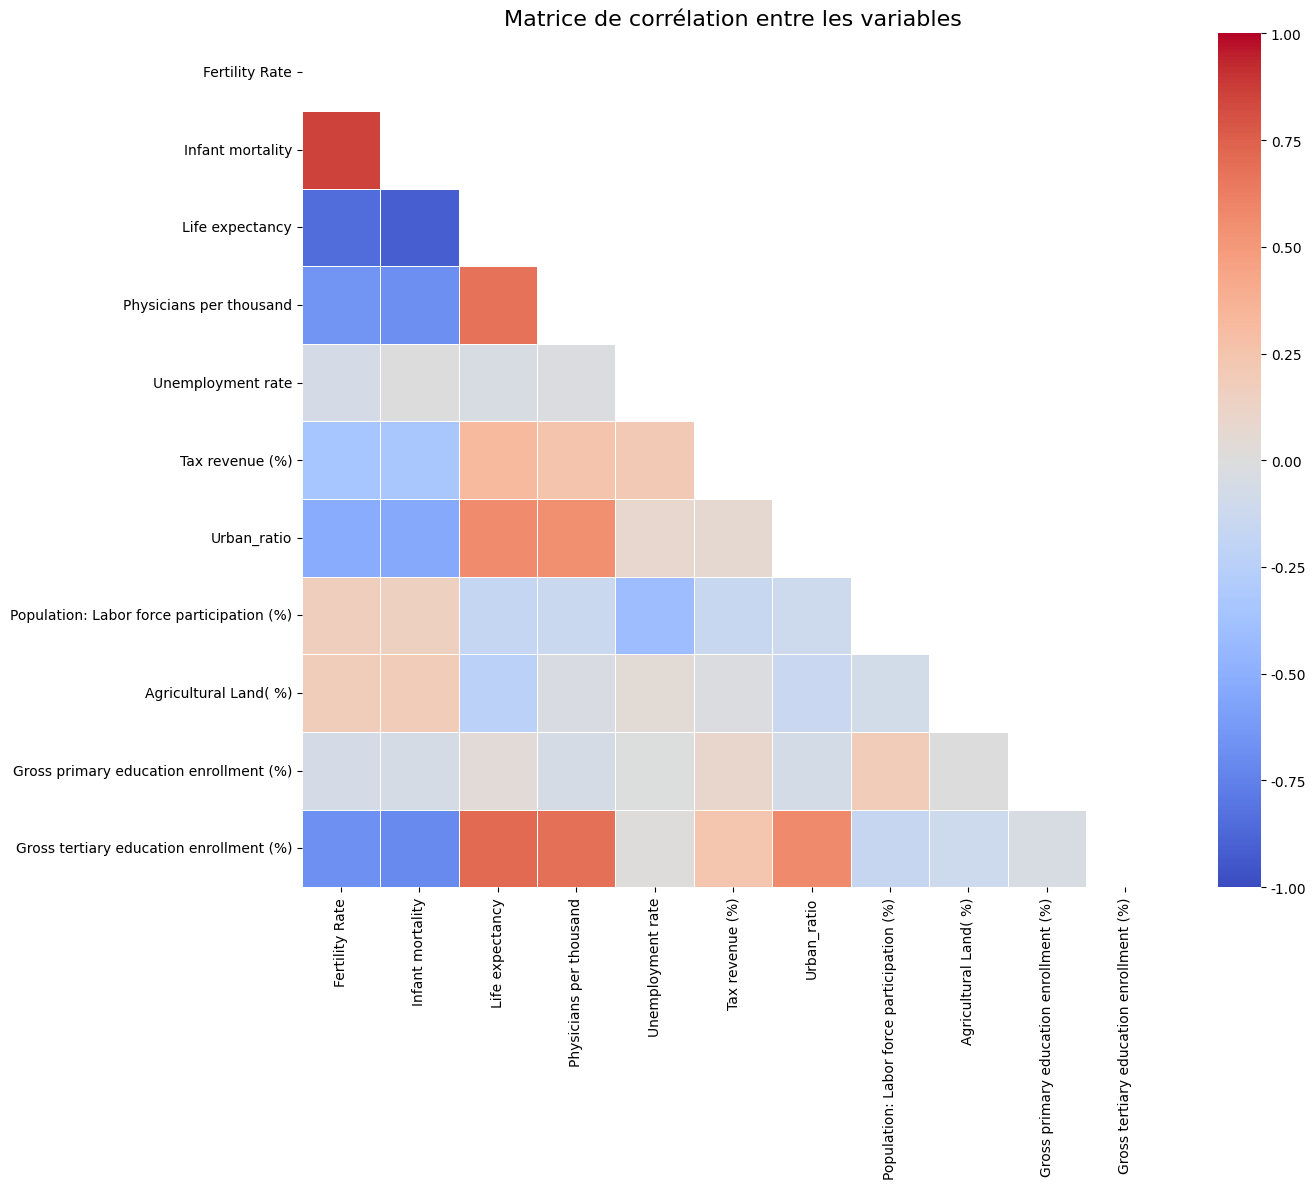

In [10]:
# Matrice de corrélation
plt.figure(figsize=(14, 12))
corr_matrix = X_clean.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm',
            linewidths=0.5, vmin=-1, vmax=1)
plt.title("Matrice de corrélation entre les variables", fontsize=16)
plt.tight_layout()
plt.show()

## 4. Préparation pour l'ACP - Standardisation des données
Avant d'appliquer l'ACP, nous standardisons les données (moyenne=0, écart-type=1)

In [11]:
# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)
print("Données standardisées:", X_scaled.shape)

Données standardisées: (191, 11)


## 5. Application de l'ACP
On applique une ACP pour réduire la dimensionnalité et analyser les composantes principales.

In [12]:
# Application de l'ACP avec toutes les composantes
pca_full = decomposition.PCA()
pca_full.fit(X_scaled)

# Variance expliquée
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

### Visualisation de la variance expliquée

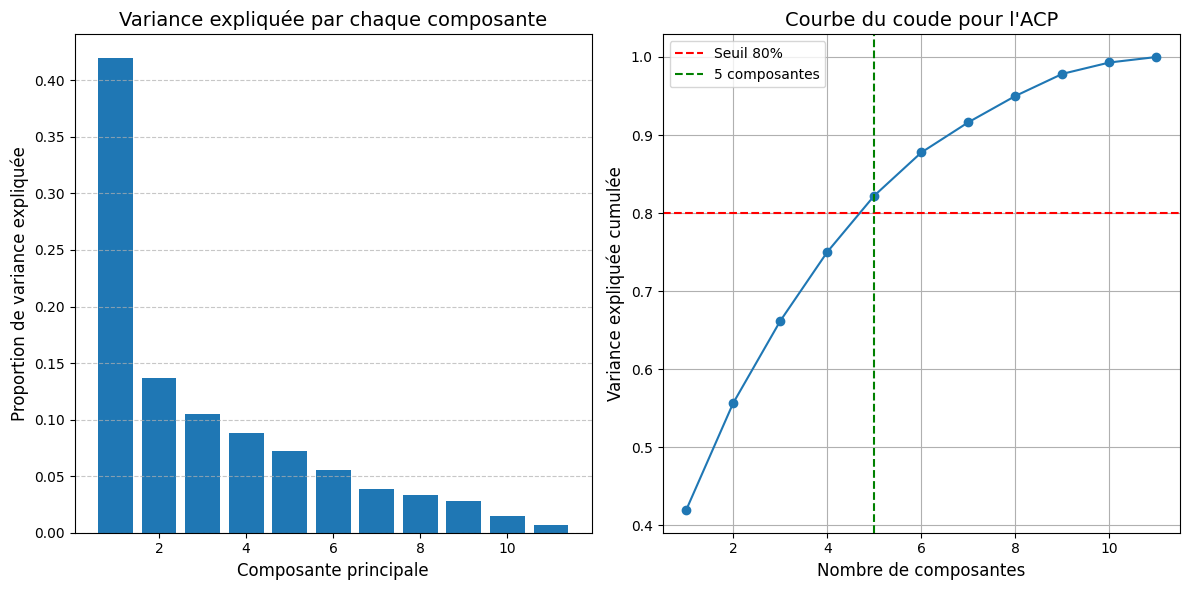


Les 5 premières composantes expliquent plus de 80% de la variance

Variance expliquée par les 10 premières composantes:
PC1: 0.4196 (0.4196 cumulée)
PC2: 0.1371 (0.5567 cumulée)
PC3: 0.1051 (0.6618 cumulée)
PC4: 0.0884 (0.7502 cumulée)
PC5: 0.0722 (0.8224 cumulée)
PC6: 0.0553 (0.8777 cumulée)
PC7: 0.0387 (0.9164 cumulée)
PC8: 0.0337 (0.9501 cumulée)
PC9: 0.0283 (0.9784 cumulée)
PC10: 0.0145 (0.9930 cumulée)


In [13]:
# Affichage de la variance expliquée
plt.figure(figsize=(12, 6))

# Graphique 1: variance expliquée par chaque composante
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel("Composante principale", fontsize=12)
plt.ylabel("Proportion de variance expliquée", fontsize=12)
plt.title("Variance expliquée par chaque composante", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Graphique 2: variance expliquée cumulée (courbe du coude)
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.8, color='r', linestyle='--', label="Seuil 80%")
components_for_80 = np.where(cumulative_variance >= 0.8)[0][0] + 1
plt.axvline(x=components_for_80, color='g', linestyle='--',
            label=f"{components_for_80} composantes")
plt.xlabel("Nombre de composantes", fontsize=12)
plt.ylabel("Variance expliquée cumulée", fontsize=12)
plt.title("Courbe du coude pour l'ACP", fontsize=14)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\nLes {components_for_80} premières composantes expliquent plus de 80% de la variance")
print("\nVariance expliquée par les 10 premières composantes:")
for i, var in enumerate(explained_variance[:10]):
    print(f"PC{i+1}: {var:.4f} ({cumulative_variance[i]:.4f} cumulée)")

## 6. Analyse des composantes principales
Analysons la contribution des variables aux composantes principales.

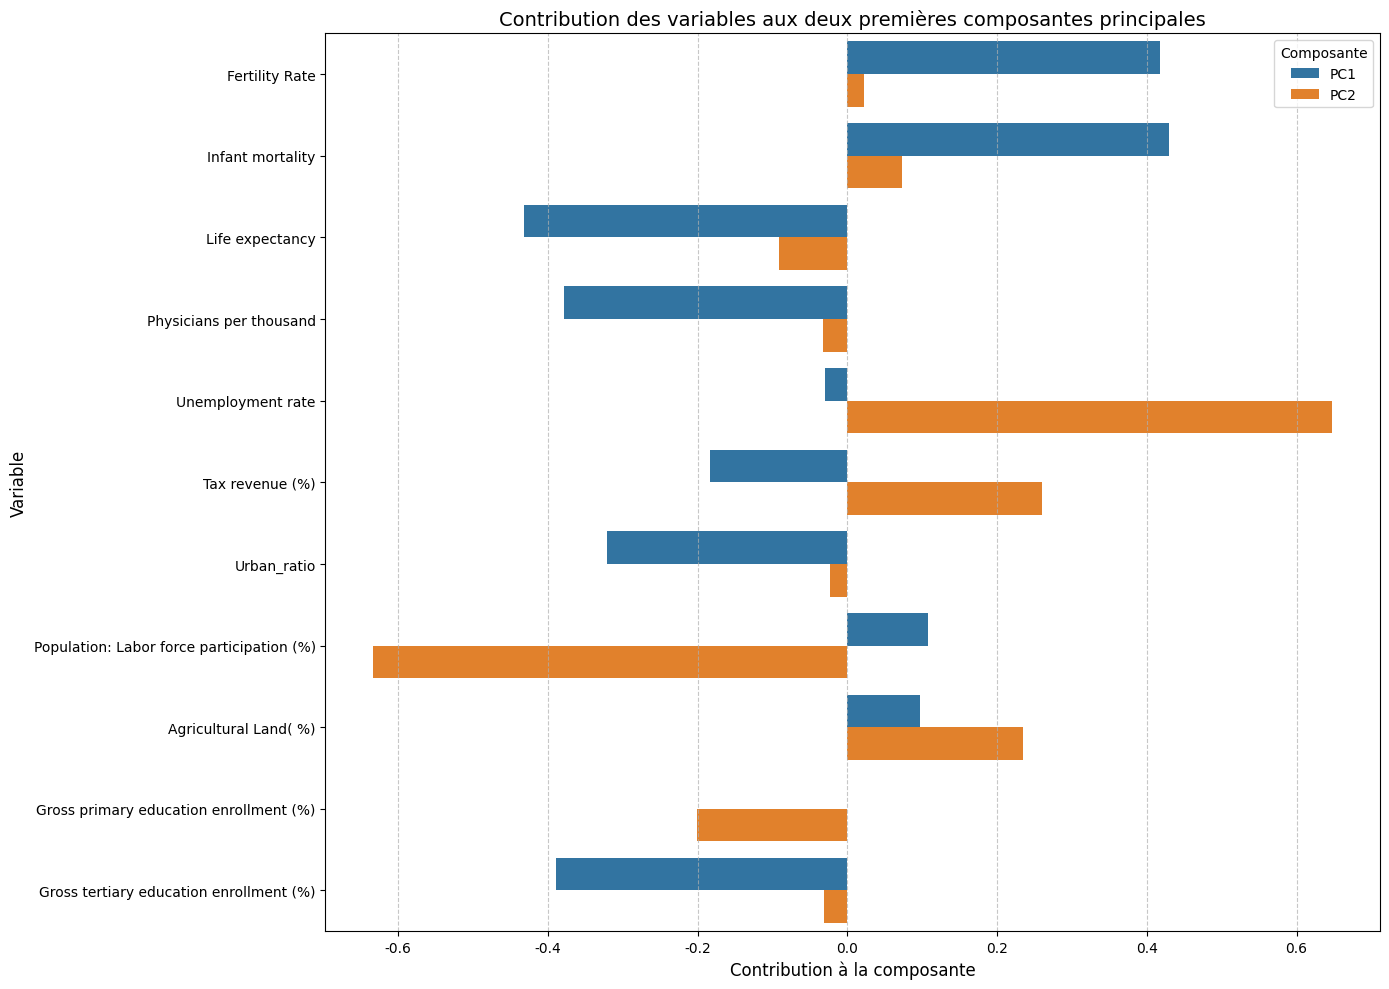

In [14]:
# Chargement des composantes
components = pca_full.components_

# Contribution des variables aux deux premières composantes
plt.figure(figsize=(14, 10))
component_names = [f"PC{i+1}" for i in range(2)]
variable_names = X_clean.columns

contribution_df = pd.DataFrame(components[:2].T, columns=component_names, index=variable_names)
contribution_df = contribution_df.reset_index().melt(id_vars="index",
                                                  value_name="contribution",
                                                  var_name="composante")

sns.barplot(x="contribution", y="index", hue="composante", data=contribution_df)
plt.xlabel("Contribution à la composante", fontsize=12)
plt.ylabel("Variable", fontsize=12)
plt.title("Contribution des variables aux deux premières composantes principales", fontsize=14)
plt.legend(title="Composante")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 7. Visualisation des données dans l'espace réduit (2D et 3D)
Projetons les données dans l'espace des composantes principales.

In [15]:
# Transformation des données
X_pca = pca_full.transform(X_scaled)

# Création d'un DataFrame avec les résultats pour faciliter la visualisation
pca_df = pd.DataFrame(data=X_pca[:, :5],
                    columns=[f'PC{i+1}' for i in range(5)])
pca_df['Pays'] = df['Country'] if 'Country' in df.columns else range(len(df))

### Visualisation 2D (PC1 vs PC2)

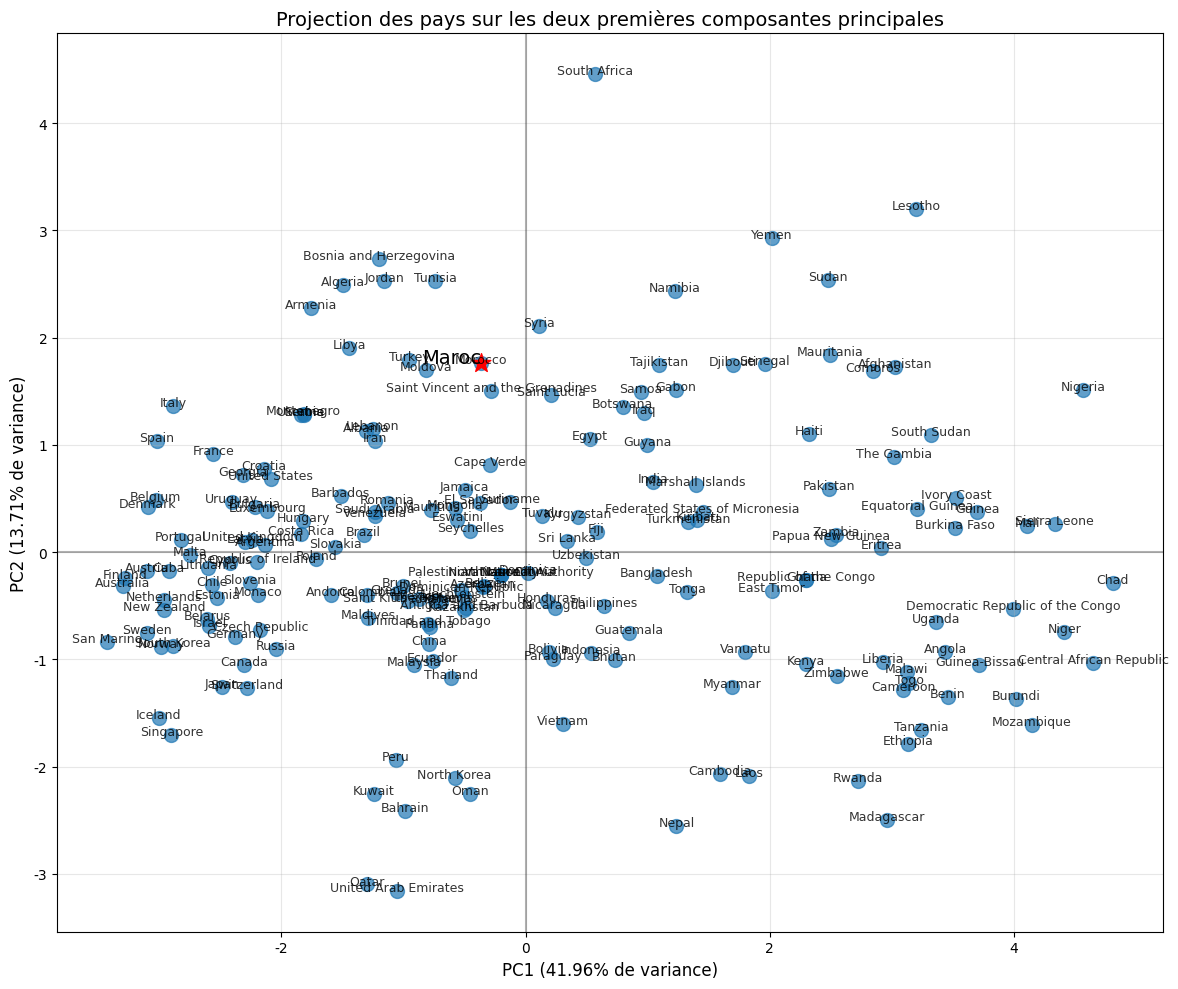

In [24]:
plt.figure(figsize=(12, 10))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'],
                    c=y if 'Region' in df.columns else None,
                    cmap='viridis', alpha=0.7, s=100)

# Ajout des étiquettes pour certains pays importants
for idx, row in pca_df.iterrows():
    # Marquer le Maroc en rouge
    if 'Country' in df.columns and df.loc[idx, 'Country'] == 'Morocco':
        plt.scatter(row['PC1'], row['PC2'], color='red', s=200, marker='*')
        plt.text(row['PC1'], row['PC2'], 'Maroc', fontsize=14, ha='right')

    # Ajouter quelques autres pays pour référence (G7 ou autres pays importants)
    important_countries = ['United States', 'China', 'Japan', 'Germany',
                         'United Kingdom', 'France', 'India', 'Brazil']
    #if 'Country' in df.columns and df.loc[idx, 'Country'] in important_countries:
    plt.text(row['PC1'], row['PC2'], df.loc[idx, 'Country'],fontsize=9, alpha=0.8, ha='center')

plt.xlabel(f"PC1 ({explained_variance[0]:.2%} de variance)", fontsize=12)
plt.ylabel(f"PC2 ({explained_variance[1]:.2%} de variance)", fontsize=12)
plt.title("Projection des pays sur les deux premières composantes principales", fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

### Visualisation 3D (PC1, PC2, PC3)

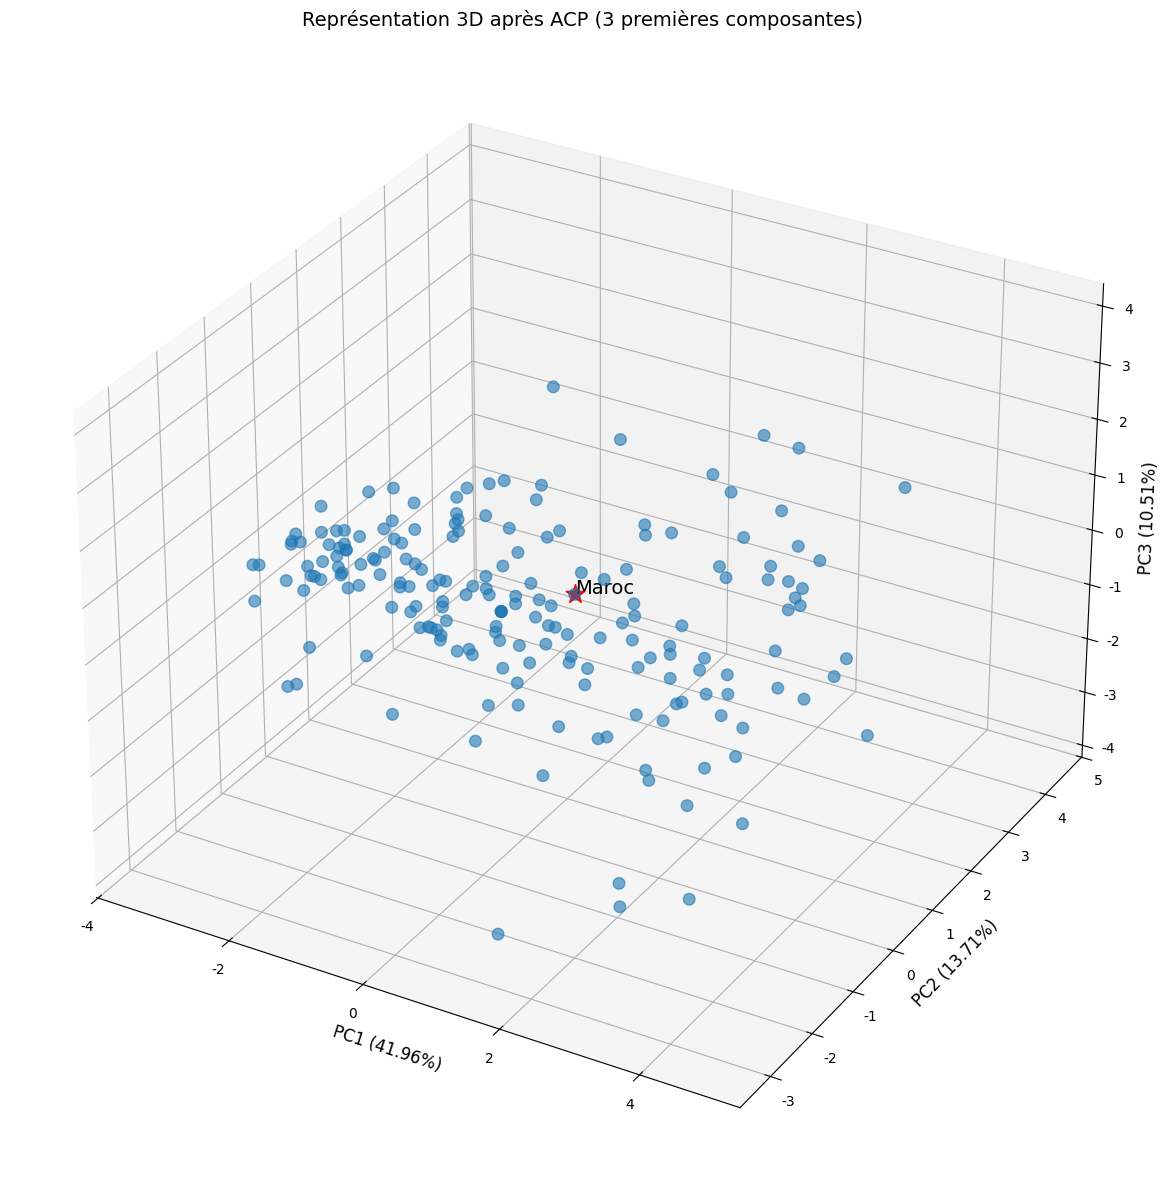

In [17]:
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
scatter3d = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                    c=y if 'Region' in df.columns else None,
                    cmap='viridis', s=70, alpha=0.6)

# Marquage du Maroc
if len(morocco_idx) > 0:
    morocco_pc1 = X_pca[morocco_idx[0], 0]
    morocco_pc2 = X_pca[morocco_idx[0], 1]
    morocco_pc3 = X_pca[morocco_idx[0], 2]
    ax.scatter([morocco_pc1], [morocco_pc2], [morocco_pc3],
             color='red', s=200, marker='*', label='Maroc')
    ax.text(morocco_pc1, morocco_pc2, morocco_pc3, 'Maroc', fontsize=14)

ax.set_xlabel(f"PC1 ({explained_variance[0]:.2%})", fontsize=12)
ax.set_ylabel(f"PC2 ({explained_variance[1]:.2%})", fontsize=12)
ax.set_zlabel(f"PC3 ({explained_variance[2]:.2%})", fontsize=12)
plt.title("Représentation 3D après ACP (3 premières composantes)", fontsize=14)
plt.tight_layout()
plt.show()

## 8. Analyse approfondie du Maroc
Examinons où se situe le Maroc par rapport aux autres pays dans l'espace des composantes principales.

In [18]:
if len(morocco_idx) > 0:
        # Position du Maroc dans l'espace PCA
        morocco_pca = X_pca[morocco_idx[0]]

        # Calcul des distances euclidiennes
        distances = []
        for i, country in enumerate(df['Country'] if 'Country' in df.columns else range(len(df))):
            if i != morocco_idx[0]:  # Exclure le Maroc lui-même
                # Distance euclidienne dans l'espace des 5 premières composantes
                dist = np.linalg.norm(morocco_pca[:5] - X_pca[i, :5])
                distances.append((country, dist))

        # Tri des pays par proximité avec le Maroc
        distances.sort(key=lambda x: x[1])

        print("\nPays les plus similaires au Maroc (dans l'espace PCA):")
        for country, dist in distances[:10]:
            print(f"{country}: distance = {dist:.4f}")

        print("\nPays les plus différents du Maroc (dans l'espace PCA):")
        for country, dist in distances[-10:]:
            print(f"{country}: distance = {dist:.4f}")


Pays les plus similaires au Maroc (dans l'espace PCA):
Tunisia: distance = 1.2323
Albania: distance = 1.6448
Kyrgyzstan: distance = 1.8345
Turkey: distance = 1.9176
Botswana: distance = 1.9301
India: distance = 1.9518
Bosnia and Herzegovina: distance = 1.9745
Armenia: distance = 2.0128
Mauritius: distance = 2.0413
Mongolia: distance = 2.0535

Pays les plus différents du Maroc (dans l'espace PCA):
Kuwait: distance = 5.7883
Madagascar: distance = 5.8097
United Arab Emirates: distance = 5.9264
Mozambique: distance = 5.9607
Mali: distance = 6.0268
Nigeria: distance = 6.2626
Chad: distance = 6.2984
Central African Republic: distance = 6.4641
Niger: distance = 6.7461
Equatorial Guinea: distance = 6.8513


### Visualisation des pays similaires au Maroc

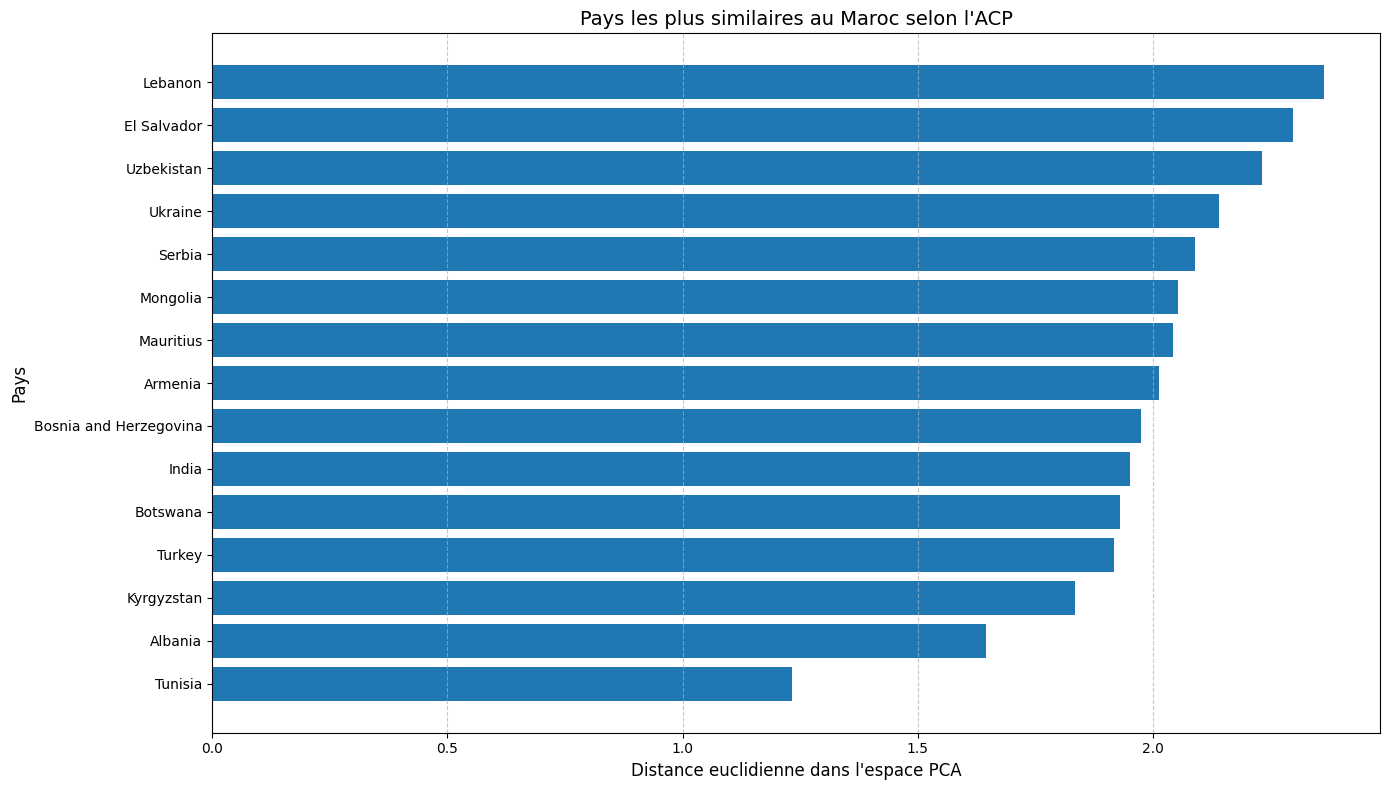

In [19]:
if len(morocco_idx) > 0:
    # Visualisation des distances
    plt.figure(figsize=(14, 8))
    closest_countries = [x[0] for x in distances[:15]]
    closest_distances = [x[1] for x in distances[:15]]

    plt.barh(closest_countries, closest_distances)
    plt.xlabel("Distance euclidienne dans l'espace PCA", fontsize=12)
    plt.ylabel("Pays", fontsize=12)
    plt.title("Pays les plus similaires au Maroc selon l'ACP", fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## 9. Analyse des groupes (clusters) dans l'espace PCA
Utilisons l'algorithme K-means pour identifier des groupes de pays similaires.

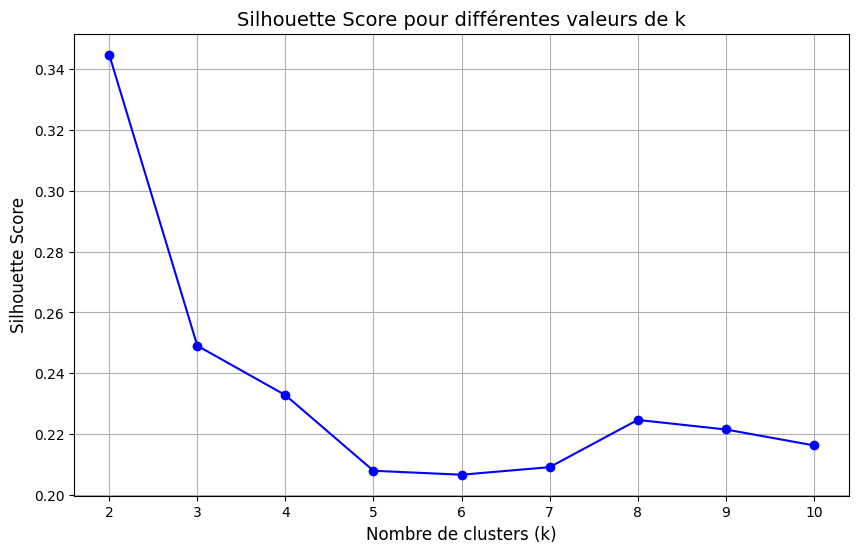

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Détermination du nombre optimal de clusters avec la méthode du silhouette score
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca[:, :5])  # Utiliser les 5 premières composantes
    score = silhouette_score(X_pca[:, :5], kmeans.labels_)
    silhouette_scores.append(score)

# Visualisation du silhouette score
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Nombre de clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score pour différentes valeurs de k', fontsize=14)
plt.grid(True)
plt.show()

### Application de K-means avec le nombre optimal de clusters

In [21]:
optimal_k = K[np.argmax(silhouette_scores)]
print(f"\nNombre optimal de clusters: {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca[:, :5])

# Ajout des labels de cluster au DataFrame
pca_df['Cluster'] = cluster_labels


Nombre optimal de clusters: 2


### Visualisation des clusters


Le Maroc appartient au cluster 0

Autres pays du même cluster que le Maroc:
Uruguay, Saudi Arabia, Kazakhstan, El Salvador, Syria, Moldova, Ukraine, United Kingdom, Mongolia, Tunisia, Republic of Ireland, Lebanon, Denmark, Tuvalu, Cuba, Armenia, Romania, Hungary, Azerbaijan, China
... et 98 autres


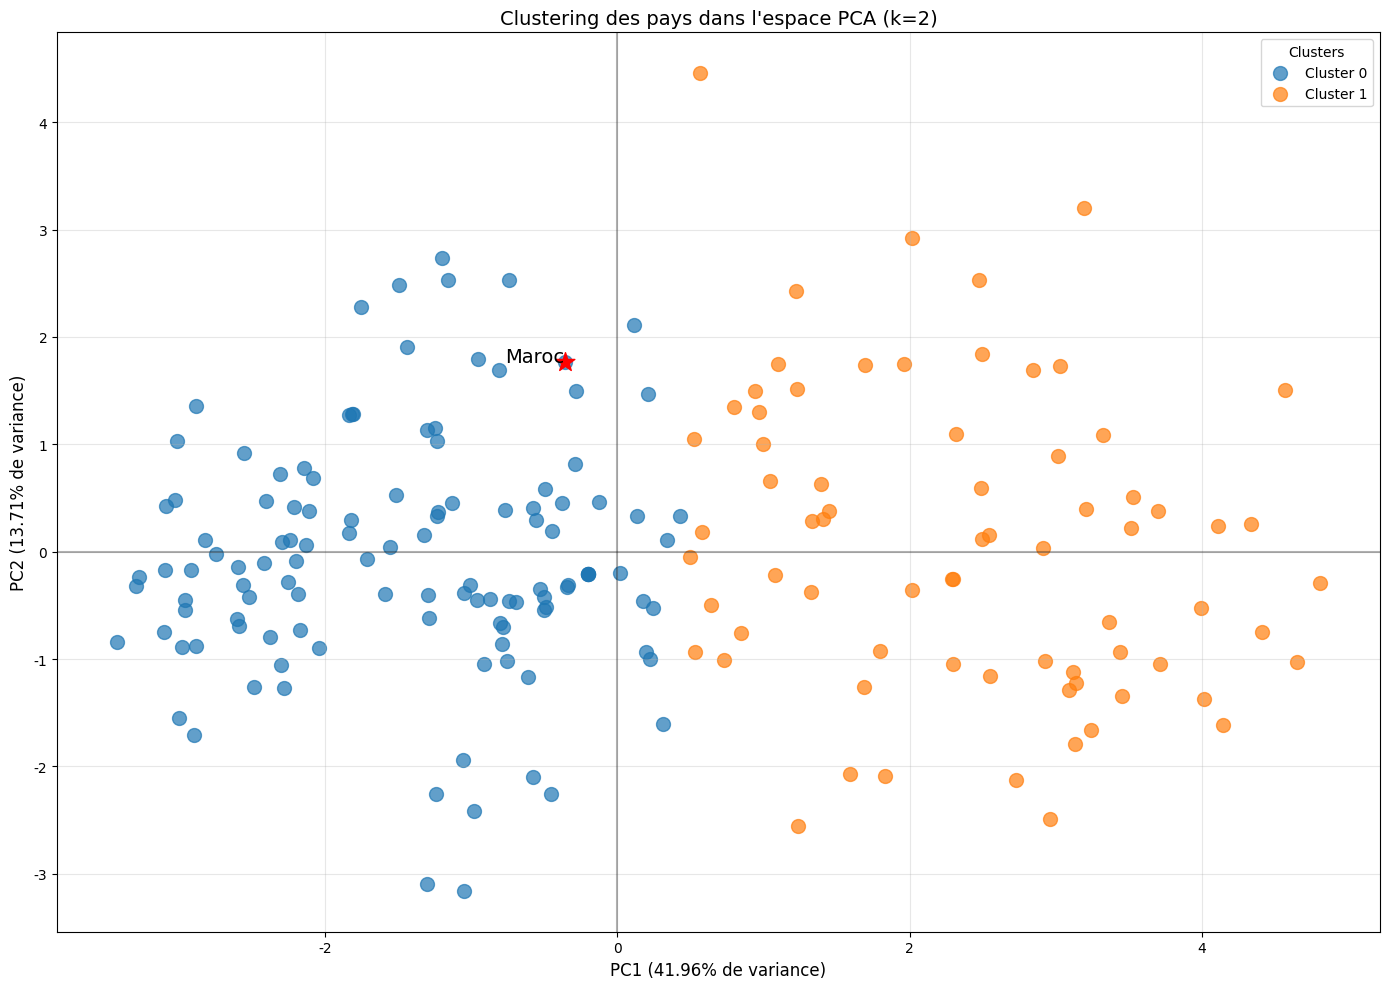

In [22]:
plt.figure(figsize=(14, 10))
for cluster in range(optimal_k):
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'],
              s=100, label=f'Cluster {cluster}', alpha=0.7)

# Marquage du Maroc
if len(morocco_idx) > 0:
    morocco_pc1 = pca_df.iloc[morocco_idx[0]]['PC1']
    morocco_pc2 = pca_df.iloc[morocco_idx[0]]['PC2']
    morocco_cluster = pca_df.iloc[morocco_idx[0]]['Cluster']
    plt.scatter(morocco_pc1, morocco_pc2, color='red', s=200, marker='*')
    plt.text(morocco_pc1, morocco_pc2, 'Maroc', fontsize=14, ha='right')
    print(f"\nLe Maroc appartient au cluster {morocco_cluster}")

    # Trouver les autres pays du même cluster
    same_cluster_countries = df.loc[pca_df[pca_df['Cluster'] == morocco_cluster].index, 'Country'].tolist()
    same_cluster_countries.remove('Morocco')  # Retirer le Maroc de la liste
    print(f"\nAutres pays du même cluster que le Maroc:")
    print(", ".join(same_cluster_countries[:20]))  # Limiter à 20 pays pour la lisibilité
    if len(same_cluster_countries) > 20:
        print(f"... et {len(same_cluster_countries) - 20} autres")

plt.xlabel(f"PC1 ({explained_variance[0]:.2%} de variance)", fontsize=12)
plt.ylabel(f"PC2 ({explained_variance[1]:.2%} de variance)", fontsize=12)
plt.title(f"Clustering des pays dans l'espace PCA (k={optimal_k})", fontsize=14)
plt.legend(title="Clusters")
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Biplot - Visualisation des variables et observations
Le biplot permet de visualiser simultanément les observations (pays) et les variables dans l'espace PCA.

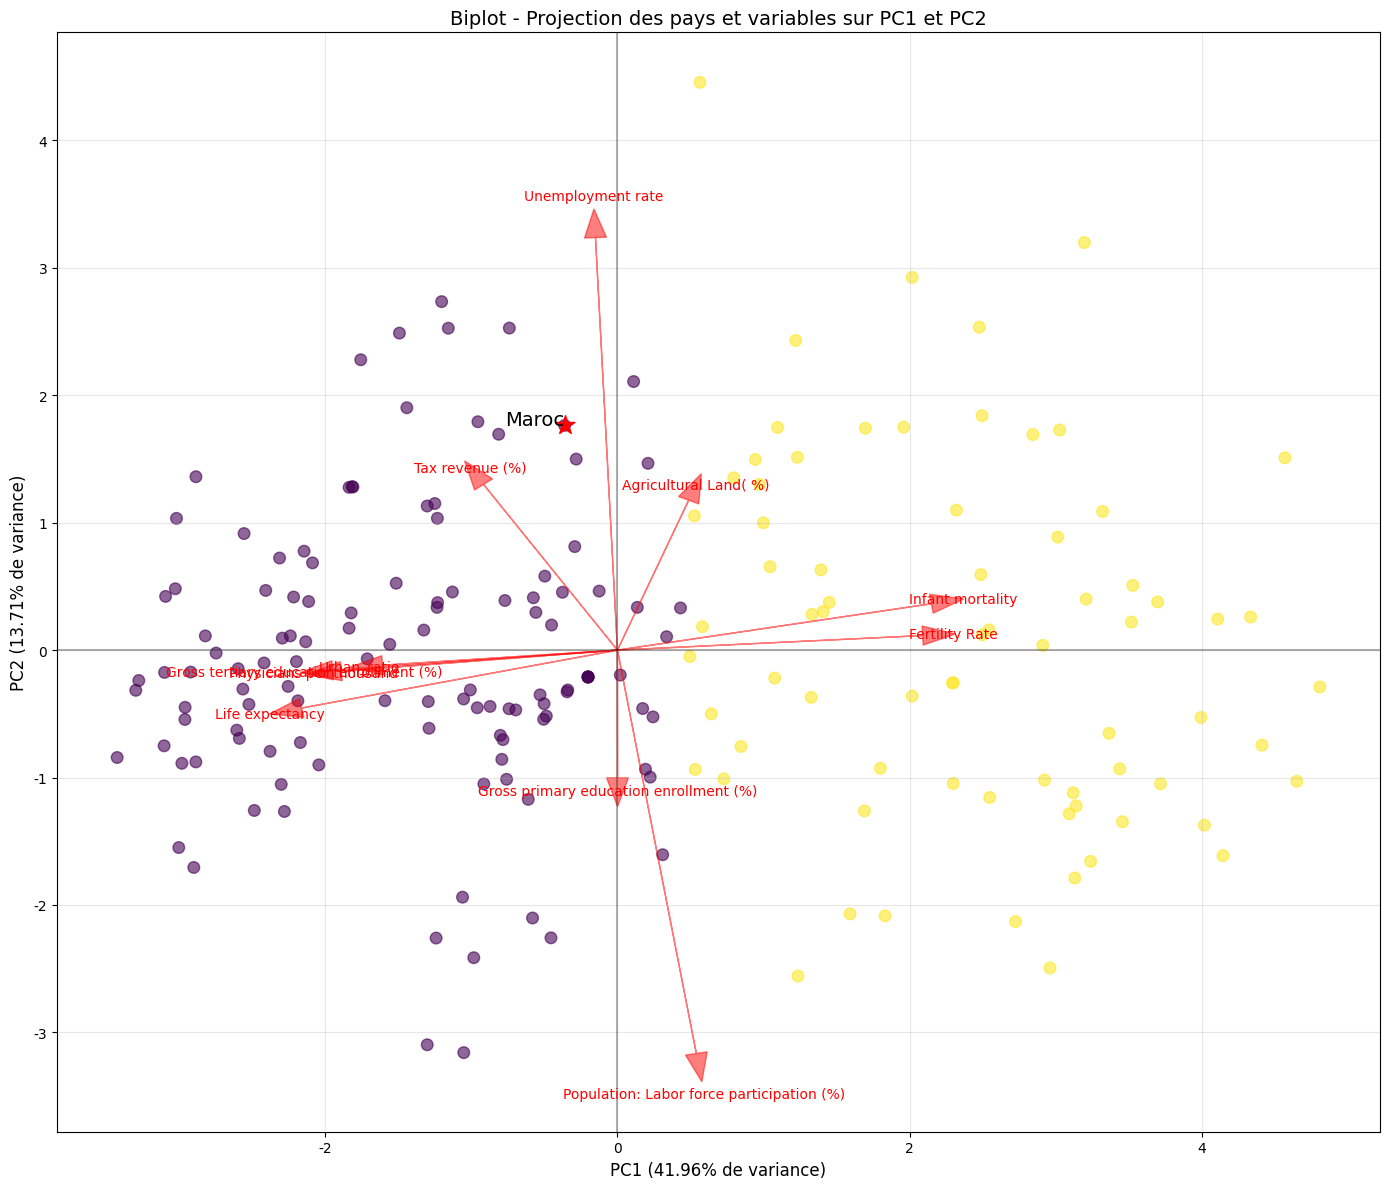

In [23]:
# Création du biplot
plt.figure(figsize=(14, 12))

# Scaling factor pour les flèches des variables
scale = 5

# Plot des observations (pays)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, s=70)

# Plot des flèches pour les variables (limiter aux plus importantes)
feature_weights = abs(components[0]) + abs(components[1])  # Importance dans PC1 et PC2
top_features_idx = np.argsort(feature_weights)[-15:]  # Top 15 variables
top_features = np.array(list(X_clean.columns))[top_features_idx]

for i, feature in zip(top_features_idx, top_features):
    plt.arrow(0, 0, components[0, i] * scale, components[1, i] * scale,
             color='r', alpha=0.5, head_width=0.15)
    plt.text(components[0, i] * scale * 1.1, components[1, i] * scale * 1.1,
           feature, color='r', ha='center', va='center')

# Marquer le Maroc
if len(morocco_idx) > 0:
    plt.scatter(X_pca[morocco_idx[0], 0], X_pca[morocco_idx[0], 1],
              color='red', s=200, marker='*')
    plt.text(X_pca[morocco_idx[0], 0], X_pca[morocco_idx[0], 1],
           'Maroc', fontsize=14, ha='right')

plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.xlabel(f"PC1 ({explained_variance[0]:.2%} de variance)", fontsize=12)
plt.ylabel(f"PC2 ({explained_variance[1]:.2%} de variance)", fontsize=12)
plt.title("Biplot - Projection des pays et variables sur PC1 et PC2", fontsize=14)
plt.tight_layout()
plt.show()

## 11. Conclusion et insights

Dans cette analyse en composantes principales du jeu de données mondial:

1. **Réduction de dimensionnalité**: Nous avons réduit un grand nombre de variables à quelques composantes principales significatives.

2. **Positionnement du Maroc**: Nous avons identifié où se situe le Maroc dans l'espace des composantes principales et quels pays lui sont similaires.

3. **Clustering**: Nous avons regroupé les pays en clusters homogènes et déterminé à quel groupe appartient le Maroc.

4. **Interprétation des composantes**: Nous avons analysé quelles variables contribuent le plus aux composantes principales.

Cette analyse fournit une vue synthétique des pays du monde basée sur leurs caractéristiques socio-économiques, permettant de positionner le Maroc dans ce contexte global.